<a href="https://colab.research.google.com/github/dlezcan1/machine-learning-fall-2021-final-project/blob/main/Final_Deliverable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Small Molecules as Epidermal Growth Factor Receptor (EGFR) Inhibitors
CS 601.475/675 Final Project

Group 4: Dimitri Lezcano, Rishima Mukherjee, Rupsa Acharya, Harrison Khoo

All of our contributions can be found at https://github.com/dlezcan1/machine-learning-fall-2021-final-project.

# Background
Epidermal Growth Factor Receptor (EGFR) is critical in cell division signalling pathways. One common cancerous mutation is EGFR overexpression, resulting in rapid, unchecked cell proliferation. This leads to several hallmarks of cancer including angiogensis induction, metastasis, and apoptosis evasion. As EGFR overexpression is common mechanism in several cancers, it is a common therapeutic target.

In this project, we set out to classify small molecules as potential EGFR inhibitors. The inspiration and data for this project came from https://www.kaggle.com/xiaotawkaggle/inhibitors. The dataset contains candidate small molecule inhibitors for 8 different protein kinases that are targets for cancer therapies. Amongst these potential proteins, we focused this project on EGFR inhibitors because it is a frequent therapeutic target and the dataset had the most data points.

The listed small molecules were already divided into training and test datasets. Each small molecule had an associated binary label, indicating whether the molecule was a known inhibitor of EGFR. Additionally, there were 8192 molecular fingerprints previously characterized for each small molecule. Each fingerprint is associated with a certain physical characteristic of the molecule.

# Exploratory Data Analyses


### Uploading Data


GitHub: src/notebooks/ExploratoryAnalyses.ipynb, src/data/*

First column, with title '1', are the labels and each other column represents a fingerprint of the small molecule. Data is all binary.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from random import sample

hf = h5py.File("/content/drive/MyDrive/egfr_erbB1.h5", "r")
list(hf.keys())

train = pd.read_csv('/content/drive/MyDrive/egfr_erbB1_train.csv')
test = pd.read_csv('/content/drive/MyDrive/egfr_erbB1_test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Columns: 8193 entries, 1 to 0.8102
dtypes: int64(8193)
memory usage: 378.4 MB


In [10]:
ids = hf["chembl_id"] # the name of each molecules
ap = sparse.csr_matrix((hf["ap"]["data"], hf["ap"]["indices"], hf["ap"]["indptr"]), shape=[len(hf["ap"]["indptr"]) - 1, 2039])
mg = sparse.csr_matrix((hf["mg"]["data"], hf["mg"]["indices"], hf["mg"]["indptr"]), shape=[len(hf["mg"]["indptr"]) - 1, 2039])
tt = sparse.csr_matrix((hf["tt"]["data"], hf["tt"]["indices"], hf["tt"]["indptr"]), shape=[len(hf["tt"]["indptr"]) - 1, 2039])
features = sparse.hstack([ap, mg, tt]).toarray() # the samples' features, each row is a sample, and each sample has 3*2039 features
labels = hf["label"] # the label of each molecule

 ### Missingness of Data

Since we know the data is binary, 0 represents a data value and not missing data. We can check for null values, and as there are none, the data is complete.

In [ ]:
train.isnull().sum()
train.isna().sum()
# No missing values, each molecule has a value at every feature

1         0
0         0
0.1       0
0.2       0
0.3       0
         ..
0.8098    0
0.8099    0
0.8100    0
0.8101    0
0.8102    0
Length: 8193, dtype: int64

### Distribution of Data

Most features are incredibly sparse. We know each sample has over 8,000 fingerprints, and most fingerprints are 0-valued. If we look at the number of non-zero values per fingerprint, there appears to be a relatively normal distribution ranging between 0 and 250. Thus, we know that every feature is sparse. Similarly, most samples have very few 1-valued fingerprints; every sample with hundreds to thousands of nonzero values is considered an outlier.

Text(0.5, 1.0, 'Distribution of labels of samples')

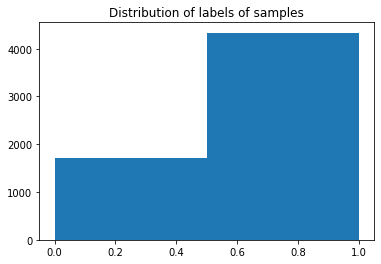

In [ ]:
#train.hist() #Let run for two hours and it did not stop running so I will show histograms for labels and random sample of features
plt.hist(train['1'], bins = 2)
plt.title('Distribution of labels of samples')

Most of the small molecule samples in the data set are indicators for EGFR.

In [ ]:
train_fea = train.drop('1', axis=1)
col_sample = train_fea.sample(n=12,axis='columns') #
col_sample.hist(bins = 2)
# each feature has mostly 0 vals

The run time to create histograms for all 8,000+ fingerprints was too long, so we decided to randomly pick a few fingerprints to represent as histograms. We also looked at features and sample distribution more holistically. From running the above code block a few times with 100 samples, the initial feeling is that most features are 0-valued across samples.

Text(0.5, 1.0, '# Nonzero data values per sample')

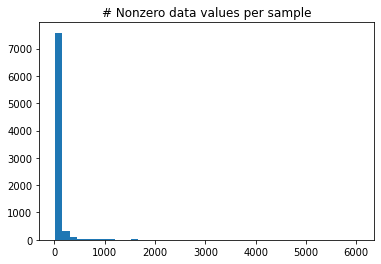

In [11]:
count_row = np.count_nonzero(train_fea, axis=0)
plt.hist(count_row, bins=40)
plt.title('# Nonzero data values per sample')
#number of nonzero values of features in each sample. There are ~8000 features, and most of the features in each sample have a zero value

Text(0.5, 1.0, '# Nonzero data values per sample')

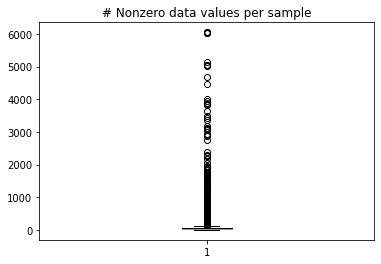

In [12]:
plt.boxplot(count_row)
plt.title('# Nonzero data values per sample')

We wanted to look at the number of nonzero data points per sample. This is visualized in  both a histogram and a boxplot. Both plots show that majority of the samples have very few non-zero fingerprint (feature values). Any sample with hundreds or thousands of nonzero data points is an outlier. Considering there 8,000+ features, it is very sparse.

Text(0.5, 1.0, '# Nonzero data values per feature')

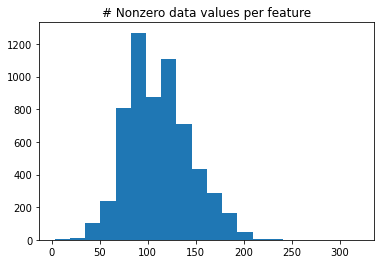

In [14]:
count_col = np.count_nonzero(train_fea, axis=1)
plt.hist(count_col, bins=20)
plt.title('# Nonzero data values per feature')
# looking at number of nonzero values in each feature 

Text(0.5, 1.0, '# Nonzero data values per feature')

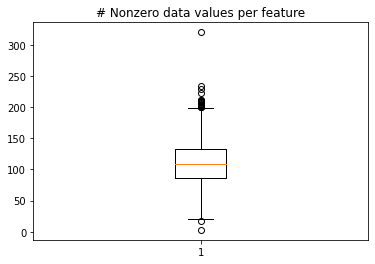

In [15]:
plt.boxplot(count_col)
plt.title('# Nonzero data values per feature')
# the number of nonzero values in each feature looks kind of normally distributed with 50% a little above 100 non-zero vals. There is some skew, but what is interesting is there is ~6000 samples but the distribution is centered in the 100s

We also looked at the number of nonzero samples per feature, or biochemical fingerprint. Again, the data was rather sparse. We trained on 6,000+ samples but the spread of nonzero data values of each feature is in the range falls between 0 to 250.

# Feature Engineering

GitHub: src/notebooks/FeatureEngineering.ipynb

Load the entire training and testing data.

In [17]:
train = np.loadtxt('/content/drive/MyDrive/egfr_erbB1_train.csv', delimiter=',')
test = np.loadtxt('/content/drive/MyDrive/egfr_erbB1_test.csv', delimiter=',')

# separate the features out
train_lbls, train_feats = train[:,0], train[:,1:]
print(train_lbls.shape, train_feats.shape)

test_lbls, test_feats = test[:,0], test[:,1:]
print(test_lbls.shape, test_feats.shape)

(6055,) (6055, 8192)
(882,) (882, 8192)


### Performing PCA

Due to the sparsity of data, PCA was used to provide a reduced and compact understanding of the features. 100 components were chosen qualitatively to characterize the dataset with a reasonable size of features. 

(200,) (200, 8192)


Text(0, 0.5, 'Singular Value')

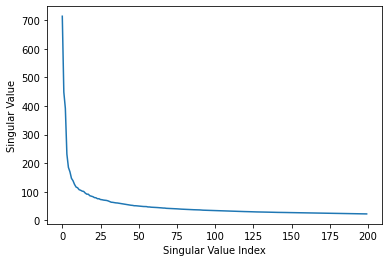

In [18]:
from sklearn.decomposition import PCA

# exploratory PCA
pca_exp = PCA(n_components=200) # 40 seems like on OK number to me, but will use 100 for large use with Neural Networks 
pca_exp.fit(train_feats)
print(pca_exp.singular_values_.shape, pca_exp.components_.shape)
plt.plot(pca_exp.singular_values_)
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')

Fit the PCA to the Training data and apply to the test data.

In [19]:
pca_feats = PCA(n_components=100)
train_feats_pca = pca_feats.fit_transform(train_feats)
print(train_feats_pca.shape)

test_feats_pca = pca_feats.transform(test_feats)
print(test_feats_pca.shape)

(6055, 100)
(882, 100)


# Neural Network Model

### Methods

GitHub: src/loss.py, main.py, models.py

A neural network model was designed using batch sampling, the adam optimizer,  and a fixed learning rate. It was trained using two different loss functions, BCE loss and focal loss, from [1] is used as the loss function to address learning on a dataset with class-imbalance and is calculated as

$$
\begin{align*}
p_t &= \begin{cases} p & \text{if } y = 1\\ 1 - p & \text{otherwise} \end{cases}\\
FL &= -(1 - p_t)^\gamma \log p_t,~~~ \gamma \geq 0
\end{align*}
$$

Where $p$ is the predicted probability of the output being true. It is a modification on Cross-entropy loss which can be changed based on varying the hyper-parameter $\gamma$.

\\
[1] Lin, T.-Y., Goyal, P., Girshick, R. B., He, K., & Dollár, P. (2017). Focal Loss for Dense Object Detection. CoRR, abs/1708.02002. Opgehaal van http://arxiv.org/abs/1708.02002

In [31]:
from google.colab import files

!cp /content/drive/MyDrive/loss.py .
!cp /content/drive/MyDrive/metrics.py .
!cp /content/drive/MyDrive/models.py .

In [32]:
from loss import FocalLoss # custom implementation of focal loss
from torch.nn.functional import binary_cross_entropy_with_logits # BCE loss used for training

Several hyperparameters were left to tune, including the number of hidden layers, size of hidden layers, loss function (BCE vs. focal), training steps, batch size, and learning rate. 

### Metrics

GitHub: src/metrics.py

To evaluate our models, we wrote a metrics function that calculated the accuracy, specificity, sensitivity, precision, recall, and f1 score for a set of predictions and true values. The f1 score is the harmonic mean of precision and recall, with the highest value being 1.

In [33]:
# some functions to evaluate accuracy and other metrics
from metrics import metrics

accuracy = lambda lbl, pred: metrics(lbl,pred)[0]

def predict(model, data):
  """ Neural network prediction """
  logits = model(data)
  pred = torch.sigmoid(logits).round()
  return pred.detach().numpy()

# predict

def print_metrics(lbl, pred):
  accuracy, specificity, sensitivity, precision, recall, f1_score  = metrics(lbl, pred)

  print("  Accuracy:", accuracy*100, '%')
  print("  Specificity:", specificity)
  print("  Sensitivity:", sensitivity)
  print("  Precision:", precision)
  print("  Recall:", recall)
  print("  F1 Score:", f1_score)

# print_metrics

Metrics run on this model using default 2 hidden layers, 10,000 training steps, and a learning rate of 0.001,  results are as follows:


In [35]:
import torch
model_nn_bce = torch.load('/content/drive/MyDrive/NN-BCE.torch')
model_nn_bce.eval()
print("BCE trained model:\n", model_nn_bce)

# performance of BCE-trained model
print("BCE Loss trained NN Performance:")
print(" Performance on Training Dataset:")
train_pred_bce = predict(model_nn_bce, (torch.from_numpy(train_feats_pca).float()))
print_metrics(train_lbls, train_pred_bce)
print(" Performance on Test Dataset:")
test_pred_bce = predict(model_nn_bce, torch.from_numpy(test_feats_pca).float())
print_metrics(test_lbls, test_pred_bce)
print() 


model_nn_focal = torch.load('/content/drive/MyDrive/NN-focal.torch')
model_nn_focal.eval()
print("Focal loss trained model:\n", model_nn_focal)

# performance of Focal Loss-trained model
print("Focal Loss (gamma=2.0) trained NN Performance:")
print(" Performance on Training Dataset:")
train_pred_focal = predict(model_nn_focal, (torch.from_numpy(train_feats_pca).float()))
print_metrics(train_lbls, train_pred_focal)
print(" Performance on Test Dataset:")
test_pred_focal = predict(model_nn_focal, torch.from_numpy(test_feats_pca).float())
print_metrics(test_lbls, test_pred_focal)


BCE trained model:
 FeedForward(
  (fc1): Linear(in_features=100, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
BCE Loss trained NN Performance:
 Performance on Training Dataset:
  Accuracy: 86.58959537572254 %
  Specificity: 0.7225130890052356
  Sensitivity: 0.922739852398524
  Precision: 0.8934792317999106
  Recall: 0.922739852398524
  F1 Score: 0.9078738370773769
 Performance on Test Dataset:
  Accuracy: 69.50113378684807 %
  Specificity: 0.5242718446601942
  Sensitivity: 0.7470414201183432
  Precision: 0.8374792703150912
  Recall: 0.7470414201183432
  F1 Score: 0.7896794370602033

Focal loss trained model:
 FeedForward(
  (fc1): Linear(in_features=100, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
Focal Loss (gamma=2.0) trained NN Performance:
 Performance on Training Dataset:
  Accuracy: 85.94549958711808 %
  Specificity: 0.7364746945898778
  Sensitivity: 0.908210332103321
  Precision: 0.89683443

### Hyperparameter Tuning
GitHub: models/*

The following neural Network hyperparameters were tuned using a grid search method:
- Number of Training Steps: 1000, 4000, 7000, 10000
- Training Batch Size: 50, 100, 150
- Learning Rate: 0.1, 0.01, 0.001
- Loss Function: focal loss, binary cross entropy
- Focal loss gamma: 1.0, 2.0, 3.0
- Number of hidden layers: 1, 2, 3

### Best Model
GitHub: src/models/NN-best.torch

The best model we found was trained with the parameters:
- Number of Training Steps: 10000
- Training Batch Size: 50
- Learning Rate: 0.001
- Loss Function: focal loss
- Focal loss gamma: 1.0
- Number of hidden layers: 1

In [36]:
model_nn_best = torch.load('/content/drive/MyDrive/NN-best.torch')
print("Best Model:\n", model_nn_best)
print(" Performance on Training Dataset:")
train_pred_best = predict(model_nn_best, (torch.from_numpy(train_feats_pca).float()))
print_metrics(train_lbls, train_pred_best)
print(" Performance on Test Dataset:")
test_pred_best = predict(model_nn_best, torch.from_numpy(test_feats_pca).float())
print_metrics(test_lbls, test_pred_best)

Best Model:
 FeedForwardNLayers(
  (inp): LinearReLU(in_features=100, out_features=100, bias=True)
  (hidden): Sequential(
    (0): LinearReLU(in_features=100, out_features=100, bias=True)
    (1): LinearReLU(in_features=100, out_features=100, bias=True)
  )
  (out): Linear(in_features=100, out_features=1, bias=True)
)
 Performance on Training Dataset:
  Accuracy: 92.056151940545 %
  Specificity: 0.8342059336823735
  Sensitivity: 0.9547970479704797
  Precision: 0.9355932203389831
  Recall: 0.9547970479704797
  F1 Score: 0.9450975915991326
 Performance on Test Dataset:
  Accuracy: 70.63492063492063 %
  Specificity: 0.42718446601941745
  Sensitivity: 0.7914201183431953
  Precision: 0.8192955589586524
  Recall: 0.7914201183431953
  F1 Score: 0.8051166290443942


# Random Forest Classifier

### Methods

GitHub: rfcmodel.py

Random forest classifier methods from sklearn.ensemble were used. Again, several hyperparameters were included for tuning. Hyperparameters included were: 
* Number of Estimators
* Maximum Number of Features
* Maximum Tree Depth
* Minimum Points to Split On
* Minimum Points per Leaf
* Bootstrap



 Included below is the testing functions: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import csv

# training function
def train( args ):
  
  # defining the model
  rf = RandomForestClassifier(bootstrap=args.bootstrap, max_depth=args.max_depth, max_features=args.max_features,
            min_samples_leaf=args.min_samples_leaf, min_samples_split=args.min_samples_split, n_estimators=args.number_estimators)

  # reshape labels
  labels_train = lbl_train.values.ravel()
  
  # fitting model
  rf.fit(feat_train, labels_train)

  # saving model
  filename = 'finalized_rfc_model.csv'
  pickle.dump(rf, open(filename, 'wb'))


# testing function
def test( args ): 

  # open model
  filename = 'finalized_rfc_model.csv'
  rf = pickle.load(open(filename, 'rb'))

  # storing predictions
  y_pred = rf.predict(feat_val)
  filename2 = 'finalized_rfc_pred.csv'
  pickle.dump(y_pred, open(filename2, 'wb'))

  # using metrics
  accuracy, specificity, sensitivity, precision, recall, f1_score = metrics(lbl_val, y_pred)
  print("Accuracy: ", accuracy, "\n", "Specificity: ", specificity, "\n", "Sensitivity: ", sensitivity,  "\n", "Precision: " , precision, "\n",  "Recall: ",  recall,  "\n", "F1 Score: ",  f1_score)


### Metrics

GitHub: src/metrics.py

The random forest classifier was initially run using default values of each hyperparameter (bootstrap = True, number of trees = 10, max features = 'auto', max depth = None, min points in a leaf = 1, and min points to split a node = 1). The model was trained and evaluated on the training set, and later evaluated on the testing set. This yielded the metrics shown below: 

In [ ]:
pred_test = pd.read_csv('/content/drive/MyDrive/ML Final Project Fall 2021/RFC_preds/finalized_rfc_pred_test.txt')
pred_train = pd.read_csv('/content/drive/MyDrive/ML Final Project Fall 2021/RFC_preds/finalized_rfc_pred_train.txt')

# performance of trained model
print("Loss trained RFC Performance:")
print(" Performance on Training Dataset:")
print_metrics(train_lbls[1:6053], pred_train)
print(" Performance on Test Dataset:")
print_metrics(test_lbls[0:879], pred_test)
print() 


Loss trained RFC Performance:
 Performance on Training Dataset:
  Accuracy: 96.43093192333113 %
  Specificity: 0.924956369982548
  Sensitivity: 0.9799215324255712
  Precision: 0.9705142857142857
  Recall: 0.9799215324255712
  F1 Score: 0.9751952227836472
 Performance on Test Dataset:
  Accuracy: 62.116040955631405 %
  Specificity: 0.2780487804878049
  Sensitivity: 0.7255192878338279
  Precision: 0.7676609105180534
  Recall: 0.7255192878338279
  F1 Score: 0.7459954233409611



### Hyperparameter Tuning

Github: HyperparameterTuningRFC.ipynb

Hyperparameter tuning for the random forest classifier was completed in two iterations, first using random search cross validation in order to narrow down ranges for each hyperparameter, and second, using grid search cross validation to identify the optimal parameters. Random search cross validation was performed on the following hyperparameters: 

*   Number of Estimators: *\[200 to 2000]*
* Maximum Number of Features: *\[auto or sqrt]*
* Maximum Tree Depth: *\[10 to 110, and None]*
* Minimum Points to Split On: *\[2, 5, or 10]*
* Minimum Points per Leaf: *\[1, 2, or 4]*
* Bootstrap: *\[True or False]*



Shown below is the first iteration:

In [ ]:

# Hyperparamater Tuning for Random Forest Classifier 

# loading the data
url_data = "https://raw.githubusercontent.com/dlezcan1/machine-learning-fall-2021-final-project/main/data/egfr_erbB1_train_pca.csv"
url_labels = "https://raw.githubusercontent.com/dlezcan1/machine-learning-fall-2021-final-project/main/data/egfr_erbB1_train_pca_labels.csv"
data = pd.read_csv(url_data, error_bad_lines=False)
labels = pd.read_csv(url_labels, error_bad_lines=False)
  
# Split training data into training and validation datasets.
feat_train, feat_val, lbl_train, lbl_val = train_test_split(data, labels, test_size=0.2, random_state=20, stratify=labels)

# initializing all possibilities for the hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(feat_train, lbl_train)
new_pred = rf_random.predict(feat_val)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
# printing the accuracy of the best model vs new model

# original model
orig_model = RandomForestClassifier()
orig_model.fit(feat_train, lbl_train)
orig_pred = orig_model.predict(feat_val)

# get best parameters
print("Best Parameters: ", rf_random.best_params_)

# get accuracies
new_model_acc = metrics(lbl_val, new_pred)
orig_model_acc = metrics(lbl_val, orig_pred)

# print accuracies
print("Original Model Accuracy: ", orig_model_acc)
print("New Model Accuracy: ", new_model_acc)
print("Improvement in Accuracy: ", new_model_acc - orig_model_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Best Parameters:  {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
Original Model Accuracy:  0.8571428571428571
New Model Accuracy:  0.8670520231213873
Improvement in Accuracy:  0.009909165978530199


Next, the second iteration of tuning using grid search cross validation was performed, using more refined values for each hyperparameter:

*   Number of Estimators: *\[70, 80, 90]*
* Maximum Number of Features: *\[auto]*
* Maximum Tree Depth: *\[10 to 110, and None]*
* Minimum Points to Split On: *\[8, 10, 12]*
* Minimum Points per Leaf: *\[1]*
* Bootstrap: *\[False]*

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [ 70, 80, 90], 
    'max_features': ['auto'],
    'min_samples_leaf': [1], # 1, 2, 3 # increased runtime so much that I ended up leaving this out
    'min_samples_split': [8, 10, 12],
    'n_estimators': [ 900, 1000, 1100],
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(feat_train, lbl_train)
best_pred = grid_search.predict(feat_val)


Fitting 2 folds for each of 27 candidates, totalling 54 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
# printing the accuracy of the best model vs new model

# get best parameters
print("Best Parameters: ", grid_search.best_params_)

# get accuracies
best_model_acc = metrics(lbl_val, best_pred)

# print
print("Original Model Accuracy: ", orig_model_acc)
print("New Model Accuracy: ", best_model_acc)
print("Improvement in Accuracy: ", best_model_acc - orig_model_acc)

Best Parameters:  {'bootstrap': False, 'max_depth': 70, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1100}
Original Model Accuracy:  0.8571428571428571
New Model Accuracy:  0.8587943848059455
Improvement in Accuracy:  0.0016515276630884035


### Best Model

The best model identified through hyperparameter tuning had parameters: 

*   Number of Estimators: *1100*
* Maximum Number of Features: *auto*
* Maximum Tree Depth: *70*
* Minimum Points to Split On: *8*
* Minimum Points per Leaf: *1*
* Bootstrap: *False*

The performance of the best model is shown below: 


In [ ]:
pred_test = pd.read_csv('/content/drive/MyDrive/ML Final Project Fall 2021/RFC_preds/best_rfc_pred_test.txt')
pred_train = pd.read_csv('/content/drive/MyDrive/ML Final Project Fall 2021/RFC_preds/best_rfc_pred_train.txt')

# performance of BCE-trained model
print("Loss trained RFC Performance:")
print(" Performance on Training Dataset:")
print_metrics(train_lbls[1:6053], pred_train)
print(" Performance on Test Dataset:")
print_metrics(test_lbls[0:879], pred_test)
print() 


Loss trained RFC Performance:
 Performance on Training Dataset:
  Accuracy: 96.43093192333113 %
  Specificity: 0.924956369982548
  Sensitivity: 0.9799215324255712
  Precision: 0.9705142857142857
  Recall: 0.9799215324255712
  F1 Score: 0.9751952227836472
 Performance on Test Dataset:
  Accuracy: 73.37883959044369 %
  Specificity: 0.05853658536585366
  Sensitivity: 0.9391691394658753
  Precision: 0.7663438256658596
  Recall: 0.9391691394658753
  F1 Score: 0.844

